# Clustering News Sources

Junita Sirait

I would like to cluster news sources based on in which subreddits they appear. First I will use k-means algorithm, then I will try out other algorithms such as DBSCAN and others. 

Table of contents add

In [203]:
import json
import pandas as pd
import numpy as np
import statistics

import tldextract

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

import math

from sklearn.feature_selection import SelectKBest
import os

<a id="sub1"></a>
## Subreddit data

In [336]:
pd = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd,"data/gm-newssources-subreddits")
dfp = os.path.join(pd,"data")
mbfc_path = os.path.join(pd, "data/mbfc")

In [337]:
with open (os.path.join(dfp,"gmm_intersection.json"), "r", encoding = "utf-8") as infile:
    gmm_intersection = json.load(infile)

In [338]:
len(gmm_intersection)

1631

In [339]:
with open (os.path.join(dfp,"gm_intersection.json"), "r", encoding = "utf-8") as infile:
    gm_intersection = json.load(infile)

In [340]:
len(gm_intersection)

42477

In [443]:
# Reading in all the subreddits in our files

with open(os.path.join(data_fp,"subreddit_ns_2021-01.json"), "r", encoding = "utf-8") as infile1a:
    subreddit_ns_jan = json.load(infile1a)

with open(os.path.join(data_fp,"subreddit_ns_2021-02.json"), "r", encoding = "utf-8") as infile2a:
    subreddit_ns_feb = json.load(infile2a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-03.json"), "r", encoding = "utf-8") as infile3a:
    subreddit_ns_march = json.load(infile3a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-04.json"), "r", encoding = "utf-8") as infile4a:
    subreddit_ns_april = json.load(infile4a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-05.json"), "r", encoding = "utf-8") as infile5a:
    subreddit_ns_may = json.load(infile5a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-06.json"), "r", encoding = "utf-8") as infile6a:
    subreddit_ns_jun = json.load(infile6a)

In [444]:
# ns_subreddit
with open(os.path.join(data_fp,"ns_subreddit_2021-01.json")) as infile1:
    ns_subreddit_01 = json.load(infile1)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-02.json")) as infile2:
    ns_subreddit_02 = json.load(infile2)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-03.json")) as infile3:
    ns_subreddit_03 = json.load(infile3)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-04.json")) as infile4:
    ns_subreddit_04 = json.load(infile4)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-05.json")) as infile5:
    ns_subreddit_05 = json.load(infile5)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-06.json")) as infile6:
    ns_subreddit_06 = json.load(infile6)

In [445]:
# for sanity check
subreddit_ns_jan["learnwelsh"]

{'wikipedia.org': [3, 2.9, 2],
 'reddit.com': [72, 68.70000000000003, 340],
 'youtube.com': [2, 1.96, 1],
 'bbc.co.uk': [3, 2.93, 23],
 'facebook.com': [5, 4.67, 16],
 'mit.edu': [1, 1.0, 0],
 'wiktionary.org': [2, 2.0, 0]}

## Apparently for some reason Reddit indexes many users as subreddits

In [446]:
sr_union_old = (
      set(subreddit_ns_jan) | set(subreddit_ns_feb) |
      set(subreddit_ns_march) | set(subreddit_ns_april) |
      set(subreddit_ns_may) | set(subreddit_ns_jun))

In [447]:
"learnwelsh" in sr_union_old

True

In [448]:
u_s = [s for s in sr_union_old if s.startswith("u_")]
len(u_s)

910554

In [449]:
u_s[:5]

['u_mariahgracew', 'u_forrest-kennedy', 'u_bharait', 'u_asds754', 'u_shakamya']

In [450]:
"u_toronto_news" in u_s

True

## Let's exclude `u_*` from our subreddits and non_news from our news sources

In [451]:
non_news = []
with open("non_news.csv", "r", encoding="utf-8") as nn:
    r = csv.reader(nn, delimiter=",")
    counter = 0
    for row in r:
        if counter != 0:
            non_news.append(row[0])
        counter += 1
len(non_news)

130

In [452]:
files_sub = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
files_ns = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

Removing from files_sub

In [453]:
len(subreddit_ns_jan)

411723

In [454]:
for f in files_sub:
    [f.pop(u) for u in u_s if u in f]

In [1]:
len(subreddit_ns_jan)

NameError: name 'subreddit_ns_jan' is not defined

In [456]:
files_sub = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
files_ns = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

In [457]:
for f in files_sub:
    for n in f:
        if 'reddit.com' in f[n]: f[n].pop('reddit.com')
        # removing each of the non_news
        for nns in non_news:
            if nns in f[n]: f[n].pop(nns)
    print("Done for a file")

Done for a file
Done for a file
Done for a file
Done for a file
Done for a file
Done for a file


In [458]:
"u_toronto_news" in subreddit_ns_jun

False

In [459]:
"learnwelsh" in subreddit_ns_jun

True

Now that we have removed `reddit.com` from various subreddits, there would be subreddits that used to only have reddit.com but now does not have anything inside. Let's get rid of these subreddits as well.

In [460]:
files_sub = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
files_ns = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

In [461]:
for s in files_sub:
    empty_subs = set()
    for k in s:
        if len(s[k]) == 0: empty_subs.add(k)
    print(len(empty_subs))
    [s.pop(u) for u in empty_subs]
    print("done for a file")

183592
done for a file
184349
done for a file
203649
done for a file
210354
done for a file
247206
done for a file
263501
done for a file


In [462]:
'ureddit' in empty_subs

False

In [463]:
'learnwelsh' in empty_subs

False

    for f in files_sub:
        [f.pop(u) for u in empty_subs if u in f]
        print("done for a file")

In [464]:
subreddit_ns_jan["learnwelsh"]

{'bbc.co.uk': [3, 2.93, 23],
 'mit.edu': [1, 1.0, 0],
 'wiktionary.org': [2, 2.0, 0]}

Instead of removing from files_ns, I will reconstruct files_ns from files_sub.

In [465]:
def ns_from_sub(subfile):
    d = defaultdict(dict)
    for sub in subfile:
        for n in subfile[sub]:
            d[n][sub] = subfile[sub][n]
    return d

In [466]:
ns_subreddit_01 = ns_from_sub(subreddit_ns_jan)
ns_subreddit_02 = ns_from_sub(subreddit_ns_feb)
ns_subreddit_03 = ns_from_sub(subreddit_ns_march)
ns_subreddit_04 = ns_from_sub(subreddit_ns_april)
ns_subreddit_05 = ns_from_sub(subreddit_ns_may)
ns_subreddit_06 = ns_from_sub(subreddit_ns_jun)

In [467]:
'reddit.com' in ns_subreddit_02

False

Let's use the intersection in an alphabetical order as a fixed order of our subreddits.

In [468]:
subs = sorted(set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

In [469]:
subs[:5]

['0xProject', '1001Movies', '100movies365days', '100yearsago', '12thMan']

## Intersections and unions of subreddits

In [470]:
# what about their intersection?
sr_intersection = (
      set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

print("intersection:", len(sr_intersection))

intersection: 10194


In [471]:
sr_union = (
      set(subreddit_ns_jan) | set(subreddit_ns_feb) |
      set(subreddit_ns_march) | set(subreddit_ns_april) |
      set(subreddit_ns_may) | set(subreddit_ns_jun))

print("union:", len(sr_union))

union: 68224


<a id="sub2"></a>
## News sources data

How many news sources are there?

In [472]:
# union
ns_union = (set(ns_subreddit_01) |
       set(ns_subreddit_02) |
       set(ns_subreddit_03) |
       set(ns_subreddit_04) |
       set(ns_subreddit_05) |
       set(ns_subreddit_06))

len(ns_union)

23776

In [473]:
nss = (set(ns_subreddit_01) &
       set(ns_subreddit_02) &
       set(ns_subreddit_03) &
       set(ns_subreddit_04) &
       set(ns_subreddit_05) &
       set(ns_subreddit_06))

In [474]:
num_ns = len(nss)
num_ns

8835

## For each news source, let's count in how many subreddits they appear

In [475]:
subreddit_count = dict()
for ns in ns_union:
    subreddit_count[ns] = len(set(ns_subreddit_01.get(ns, dict()).keys()) 
                               | set(ns_subreddit_02.get(ns, dict()).keys()) 
                               | set(ns_subreddit_03.get(ns, dict()).keys()) 
                               | set(ns_subreddit_04.get(ns, dict()).keys())
                               | set(ns_subreddit_05.get(ns, dict()).keys()) 
                               | set(ns_subreddit_06.get(ns, dict()).keys()))

`subreddit_count` stores in how many subreddits each news source appears.

In [476]:
subreddit_count['nytimes.com']

6085

In [376]:
subreddit_count_freq = dict(Counter(subreddit_count.values()).most_common())
subreddit_count_freq

{1: 4711,
 2: 2784,
 3: 1951,
 4: 1383,
 5: 1113,
 6: 911,
 7: 772,
 8: 652,
 9: 511,
 10: 475,
 11: 428,
 12: 374,
 13: 345,
 14: 318,
 15: 297,
 16: 255,
 17: 245,
 18: 215,
 19: 189,
 21: 189,
 20: 177,
 22: 171,
 24: 148,
 27: 130,
 25: 129,
 23: 124,
 28: 111,
 30: 107,
 33: 101,
 29: 97,
 26: 97,
 32: 93,
 37: 88,
 35: 83,
 31: 82,
 34: 74,
 46: 72,
 36: 72,
 40: 66,
 44: 66,
 43: 64,
 41: 64,
 38: 62,
 42: 61,
 39: 58,
 45: 57,
 49: 54,
 48: 50,
 47: 49,
 53: 49,
 56: 44,
 55: 44,
 51: 44,
 54: 42,
 50: 42,
 52: 41,
 73: 41,
 67: 41,
 60: 34,
 68: 33,
 63: 31,
 58: 31,
 62: 30,
 57: 30,
 59: 27,
 61: 27,
 64: 27,
 80: 27,
 84: 26,
 66: 26,
 75: 26,
 83: 25,
 65: 25,
 71: 25,
 70: 24,
 72: 23,
 69: 23,
 86: 23,
 89: 22,
 92: 21,
 81: 21,
 79: 21,
 85: 21,
 74: 21,
 87: 19,
 110: 19,
 82: 19,
 90: 19,
 76: 18,
 109: 18,
 100: 17,
 98: 17,
 78: 17,
 96: 16,
 102: 16,
 91: 15,
 121: 15,
 106: 15,
 77: 15,
 111: 14,
 104: 14,
 116: 14,
 103: 14,
 101: 13,
 144: 13,
 99: 13,
 133: 13,

`subreddit_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [377]:
max(subreddit_count_freq.keys())

5626

In [378]:
sde_ranked = Counter(subreddit_count).most_common()

for t in sde_ranked[:30]:
    sr, co = t
    if co > 1:
        print(f"{sr} is mentioned in {co} subreddits.")

theguardian.com is mentioned in 5626 subreddits.
nytimes.com is mentioned in 5451 subreddits.
cnn.com is mentioned in 5014 subreddits.
bbc.com is mentioned in 4246 subreddits.
reuters.com is mentioned in 3907 subreddits.
washingtonpost.com is mentioned in 3695 subreddits.
forbes.com is mentioned in 3494 subreddits.
cnbc.com is mentioned in 3361 subreddits.
bloomberg.com is mentioned in 3270 subreddits.
apnews.com is mentioned in 3085 subreddits.
businessinsider.com is mentioned in 3034 subreddits.
fandom.com is mentioned in 2983 subreddits.
bbc.co.uk is mentioned in 2976 subreddits.
npr.org is mentioned in 2910 subreddits.
nbcnews.com is mentioned in 2819 subreddits.
independent.co.uk is mentioned in 2730 subreddits.
msn.com is mentioned in 2702 subreddits.
dailymail.co.uk is mentioned in 2701 subreddits.
vice.com is mentioned in 2587 subreddits.
nypost.com is mentioned in 2445 subreddits.
wsj.com is mentioned in 2412 subreddits.
theverge.com is mentioned in 2364 subreddits.
usatoday.c

In [379]:
subreddit_count["breitbart.com"]

497

In [380]:
sc = [s for s in subreddit_count if subreddit_count[s]>=300]
len(sc)

391

```
with open("sc_ge3k.csv", "w", newline='', encoding="utf-8") as s:
    w = csv.writer(s, dialect="excel", delimiter=",")
    for c in sc:
        w.writerow([c])
```

In [381]:
sum(subreddit_count_freq.values()) == len(ns_union)

True

In [382]:
import itertools

In [383]:
scf = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in subreddit_count_freq.items()))

Text(0.5, 1.0, 'number of news sources appearing in x subreddits')

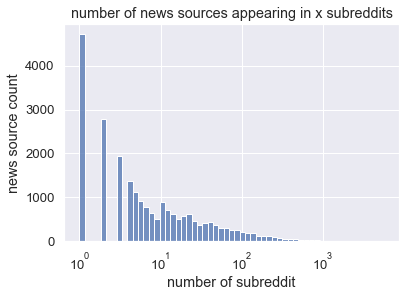

In [384]:
# sns.histplot([math.log(s,10) for s in scf])
sns.histplot(scf, log_scale=True)
plt.xlabel("number of subreddit")
plt.ylabel("news source count")
plt.title("number of news sources appearing in x subreddits")

How many news sources only appear in 10 subreddits or less? what about 9 or 8?

In [385]:
def pct_ns_in_k_subreddits(ks):
    ns_in_i_subreddit = [k for k in subreddit_count if subreddit_count[k] <= ks]
    count = len(ns_in_i_subreddit)
    print("There are {} news sources appearing in only {} subreddits or less ({}%)".format(count, ks, count/len(ns_union)))
    return count/len(ns_union)

In [386]:
pct_ns_in_k_subreddits(5)

There are 11942 news sources appearing in only 5 subreddits or less (0.5097754631605907%)


0.5097754631605907

In [387]:
pct_in_k_subreddits = [(i, pct_ns_in_k_subreddits(i)) for i in range(1000)]

There are 0 news sources appearing in only 0 subreddits or less (0.0%)
There are 4711 news sources appearing in only 1 subreddits or less (0.2011013403910185%)
There are 7495 news sources appearing in only 2 subreddits or less (0.31994365235208744%)
There are 9446 news sources appearing in only 3 subreddits or less (0.4032271834713566%)
There are 10829 news sources appearing in only 4 subreddits or less (0.46226415094339623%)
There are 11942 news sources appearing in only 5 subreddits or less (0.5097754631605907%)
There are 12853 news sources appearing in only 6 subreddits or less (0.5486638777426791%)
There are 13625 news sources appearing in only 7 subreddits or less (0.5816187142491249%)
There are 14277 news sources appearing in only 8 subreddits or less (0.609451037308973%)
There are 14788 news sources appearing in only 9 subreddits or less (0.6312644070690686%)
There are 15263 news sources appearing in only 10 subreddits or less (0.6515410227951849%)
There are 15691 news sources a

There are 21992 news sources appearing in only 98 subreddits or less (0.9387859643131563%)
There are 22005 news sources appearing in only 99 subreddits or less (0.9393409032698711%)
There are 22022 news sources appearing in only 100 subreddits or less (0.9400665926748057%)
There are 22035 news sources appearing in only 101 subreddits or less (0.9406215316315205%)
There are 22051 news sources appearing in only 102 subreddits or less (0.9413045334244002%)
There are 22065 news sources appearing in only 103 subreddits or less (0.94190215999317%)
There are 22079 news sources appearing in only 104 subreddits or less (0.9424997865619398%)
There are 22090 news sources appearing in only 105 subreddits or less (0.9429693502945445%)
There are 22105 news sources appearing in only 106 subreddits or less (0.9436096644753692%)
There are 22116 news sources appearing in only 107 subreddits or less (0.9440792282079741%)
There are 22124 news sources appearing in only 108 subreddits or less (0.94442072910

There are 22748 news sources appearing in only 193 subreddits or less (0.9710577990267224%)
There are 22750 news sources appearing in only 194 subreddits or less (0.9711431742508324%)
There are 22754 news sources appearing in only 195 subreddits or less (0.9713139246990523%)
There are 22758 news sources appearing in only 196 subreddits or less (0.9714846751472722%)
There are 22763 news sources appearing in only 197 subreddits or less (0.9716981132075472%)
There are 22766 news sources appearing in only 198 subreddits or less (0.9718261760437121%)
There are 22770 news sources appearing in only 199 subreddits or less (0.971996926491932%)
There are 22773 news sources appearing in only 200 subreddits or less (0.972124989328097%)
There are 22780 news sources appearing in only 201 subreddits or less (0.9724238026124818%)
There are 22785 news sources appearing in only 202 subreddits or less (0.9726372406727568%)
There are 22789 news sources appearing in only 203 subreddits or less (0.972807991

There are 23040 news sources appearing in only 301 subreddits or less (0.9835225817467771%)
There are 23040 news sources appearing in only 302 subreddits or less (0.9835225817467771%)
There are 23041 news sources appearing in only 303 subreddits or less (0.983565269358832%)
There are 23041 news sources appearing in only 304 subreddits or less (0.983565269358832%)
There are 23041 news sources appearing in only 305 subreddits or less (0.983565269358832%)
There are 23043 news sources appearing in only 306 subreddits or less (0.983650644582942%)
There are 23044 news sources appearing in only 307 subreddits or less (0.983693332194997%)
There are 23045 news sources appearing in only 308 subreddits or less (0.9837360198070519%)
There are 23047 news sources appearing in only 309 subreddits or less (0.983821395031162%)
There are 23047 news sources appearing in only 310 subreddits or less (0.983821395031162%)
There are 23048 news sources appearing in only 311 subreddits or less (0.98386408264321

There are 23147 news sources appearing in only 409 subreddits or less (0.9880901562366601%)
There are 23148 news sources appearing in only 410 subreddits or less (0.9881328438487151%)
There are 23149 news sources appearing in only 411 subreddits or less (0.9881755314607701%)
There are 23149 news sources appearing in only 412 subreddits or less (0.9881755314607701%)
There are 23149 news sources appearing in only 413 subreddits or less (0.9881755314607701%)
There are 23152 news sources appearing in only 414 subreddits or less (0.988303594296935%)
There are 23154 news sources appearing in only 415 subreddits or less (0.988388969521045%)
There are 23154 news sources appearing in only 416 subreddits or less (0.988388969521045%)
There are 23154 news sources appearing in only 417 subreddits or less (0.988388969521045%)
There are 23155 news sources appearing in only 418 subreddits or less (0.9884316571331%)
There are 23156 news sources appearing in only 419 subreddits or less (0.98847434474515

There are 23219 news sources appearing in only 512 subreddits or less (0.9911636643046188%)
There are 23221 news sources appearing in only 513 subreddits or less (0.9912490395287288%)
There are 23222 news sources appearing in only 514 subreddits or less (0.9912917271407837%)
There are 23222 news sources appearing in only 515 subreddits or less (0.9912917271407837%)
There are 23222 news sources appearing in only 516 subreddits or less (0.9912917271407837%)
There are 23222 news sources appearing in only 517 subreddits or less (0.9912917271407837%)
There are 23222 news sources appearing in only 518 subreddits or less (0.9912917271407837%)
There are 23222 news sources appearing in only 519 subreddits or less (0.9912917271407837%)
There are 23222 news sources appearing in only 520 subreddits or less (0.9912917271407837%)
There are 23225 news sources appearing in only 521 subreddits or less (0.9914197899769487%)
There are 23225 news sources appearing in only 522 subreddits or less (0.9914197

There are 23268 news sources appearing in only 611 subreddits or less (0.9932553572953129%)
There are 23268 news sources appearing in only 612 subreddits or less (0.9932553572953129%)
There are 23268 news sources appearing in only 613 subreddits or less (0.9932553572953129%)
There are 23269 news sources appearing in only 614 subreddits or less (0.9932980449073678%)
There are 23269 news sources appearing in only 615 subreddits or less (0.9932980449073678%)
There are 23270 news sources appearing in only 616 subreddits or less (0.9933407325194229%)
There are 23272 news sources appearing in only 617 subreddits or less (0.9934261077435328%)
There are 23273 news sources appearing in only 618 subreddits or less (0.9934687953555879%)
There are 23273 news sources appearing in only 619 subreddits or less (0.9934687953555879%)
There are 23273 news sources appearing in only 620 subreddits or less (0.9934687953555879%)
There are 23273 news sources appearing in only 621 subreddits or less (0.9934687

There are 23297 news sources appearing in only 716 subreddits or less (0.9944932980449074%)
There are 23297 news sources appearing in only 717 subreddits or less (0.9944932980449074%)
There are 23297 news sources appearing in only 718 subreddits or less (0.9944932980449074%)
There are 23297 news sources appearing in only 719 subreddits or less (0.9944932980449074%)
There are 23297 news sources appearing in only 720 subreddits or less (0.9944932980449074%)
There are 23297 news sources appearing in only 721 subreddits or less (0.9944932980449074%)
There are 23298 news sources appearing in only 722 subreddits or less (0.9945359856569623%)
There are 23298 news sources appearing in only 723 subreddits or less (0.9945359856569623%)
There are 23299 news sources appearing in only 724 subreddits or less (0.9945786732690173%)
There are 23299 news sources appearing in only 725 subreddits or less (0.9945786732690173%)
There are 23300 news sources appearing in only 726 subreddits or less (0.9946213

There are 23324 news sources appearing in only 824 subreddits or less (0.9956458635703919%)
There are 23325 news sources appearing in only 825 subreddits or less (0.9956885511824468%)
There are 23325 news sources appearing in only 826 subreddits or less (0.9956885511824468%)
There are 23325 news sources appearing in only 827 subreddits or less (0.9956885511824468%)
There are 23325 news sources appearing in only 828 subreddits or less (0.9956885511824468%)
There are 23326 news sources appearing in only 829 subreddits or less (0.9957312387945019%)
There are 23326 news sources appearing in only 830 subreddits or less (0.9957312387945019%)
There are 23326 news sources appearing in only 831 subreddits or less (0.9957312387945019%)
There are 23326 news sources appearing in only 832 subreddits or less (0.9957312387945019%)
There are 23326 news sources appearing in only 833 subreddits or less (0.9957312387945019%)
There are 23326 news sources appearing in only 834 subreddits or less (0.9957312

There are 23343 news sources appearing in only 917 subreddits or less (0.9964569281994365%)
There are 23344 news sources appearing in only 918 subreddits or less (0.9964996158114915%)
There are 23344 news sources appearing in only 919 subreddits or less (0.9964996158114915%)
There are 23344 news sources appearing in only 920 subreddits or less (0.9964996158114915%)
There are 23344 news sources appearing in only 921 subreddits or less (0.9964996158114915%)
There are 23344 news sources appearing in only 922 subreddits or less (0.9964996158114915%)
There are 23344 news sources appearing in only 923 subreddits or less (0.9964996158114915%)
There are 23344 news sources appearing in only 924 subreddits or less (0.9964996158114915%)
There are 23344 news sources appearing in only 925 subreddits or less (0.9964996158114915%)
There are 23344 news sources appearing in only 926 subreddits or less (0.9964996158114915%)
There are 23344 news sources appearing in only 927 subreddits or less (0.9964996

Text(0.5, 1.0, 'proportion of news sources appearing in x subreddits or less')

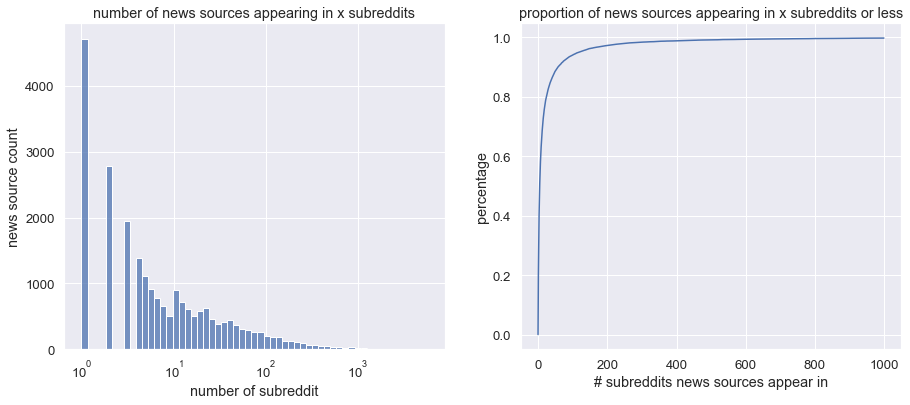

In [388]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
sns.set(font_scale = 1.2)

sns.histplot(scf, log_scale=True, ax=ax1)
ax1.set_xlabel("number of subreddit")
ax1.set_ylabel("news source count")
ax1.set_title("number of news sources appearing in x subreddits")

sns.lineplot(x=[k[0] for k in pct_in_k_subreddits],
             y=[k[1] for k in pct_in_k_subreddits],
            ax=ax2)
ax2.set_ylabel("percentage")
ax2.set_xlabel("# subreddits news sources appear in")
ax2.set_title("proportion of news sources appearing in x subreddits or less")

In [389]:
# mean
statistics.mean(scf)

31.897037479723384

In [390]:
# median
statistics.median(scf)

5.0

## For each news source let's count how many times they are shared regardless of in which subreddits

In [391]:
sum(dict().values())

0

In [392]:
def get_mention_count(ns):
    """get total mention count of ns in all six months"""
    count = 0
    files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
    for f in files:
        ns_dict = f.get(ns, dict())
        if len(ns_dict) > 0:
            mentions = sum([m[0] for m in ns_dict.values()])
            count += mentions
    return count

In [393]:
mention_count = dict()
for ns in ns_union:
    mention_count[ns] = get_mention_count(ns)

In [394]:
statistics.mean(mention_count.values())

300.9041236233245

In [395]:
statistics.stdev(mention_count.values())

3840.7896215599567

In [396]:
statistics.median(mention_count.values())

10.0

In [397]:
len(mention_count)

23426

In [398]:
Counter(mention_count).most_common(20)

[('mlb.com', 318948),
 ('theguardian.com', 225921),
 ('cnn.com', 160451),
 ('nytimes.com', 144252),
 ('foxnews.com', 141796),
 ('thehindu.com', 88410),
 ('bbc.co.uk', 87890),
 ('thestar.com', 87662),
 ('reuters.com', 85021),
 ('nypost.com', 81594),
 ('cnbc.com', 65440),
 ('thehill.com', 63500),
 ('indiatimes.com', 63034),
 ('washingtontimes.com', 59941),
 ('breitbart.com', 57660),
 ('usatoday.com', 54144),
 ('scmp.com', 52531),
 ('cbc.ca', 52372),
 ('apnews.com', 48543),
 ('nbcnews.com', 48378)]

In [399]:
news_ge10k = [m for m in mention_count if mention_count[m] >= 1000]
len(news_ge10k)

807

```
with open("news_ge10k.csv", "w", encoding="utf-8", newline='') as n:
    w = csv.writer(n, dialect="excel", delimiter=",")
    for e in news_ge10k:
        w.writerow([e])
```

In [400]:
ns_subreddit_01['cbc.ca']

{'todayilearned': [17, 14.780000000000001, 2038],
 'JoeRogan': [1, 0.76, 3],
 'knowyourshit': [3, 2.92, 1],
 'collapse': [7, 6.280000000000001, 58],
 'marginal': [3, 3.0, 0],
 'conspiracy': [11, 8.9, 649],
 'politics': [121, 107.37999999999998, 227661],
 'CPTSD': [1, 1.0, 1],
 'VideoEditing': [1, 0.98, 38],
 'wallstreetbets': [15, 13.129999999999999, 115],
 'hackernews': [8, 5.92, 8],
 'patient_hackernews': [8, 8.0, 8],
 'unitedkingdom': [2, 1.82, 19],
 'Catholicism': [1, 1.0, 2],
 'books': [6, 5.2, 15],
 'hackerdigest': [1, 1.0, 0],
 'Snorkblot': [2, 2.0, 2],
 'UnresolvedMysteries': [18, 17.439999999999998, 1033],
 'TrueUnpopularOpinion': [2, 1.3, 32],
 'SPACs': [2, 1.8, 152],
 'aznidentity': [1, 0.98, 40],
 'badgovnofreedom': [34, 34.0, 1],
 'cyberpunkgame': [1, 0.4, 3],
 'CBC_': [9, 8.84, 1],
 'newjersey': [1, 0.8, 25],
 'newfoundland': [28, 25.439999999999994, 406],
 'Hamilton': [42, 35.79, 950],
 'Oshawa': [1, 0.9, 5],
 'RedditTLDR': [5, 4.67, 1],
 'Sino': [1, 0.96, 18],
 'Sorcere

<AxesSubplot:ylabel='Count'>

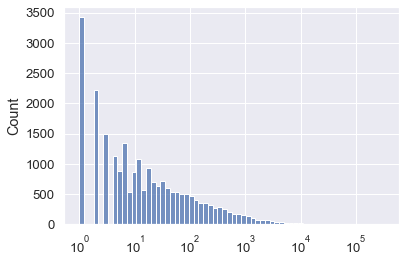

In [401]:
sns.histplot(list(mention_count.values()), log_scale=True)

<AxesSubplot:ylabel='Count'>

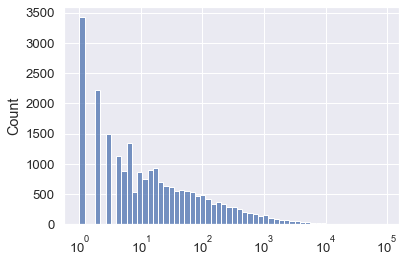

In [402]:
sns.histplot(list([k for k in mention_count.values() if k <100000]), log_scale=True)

In [403]:
len([k for k in mention_count.values() if k <5])*100/len(mention_count)

35.31973021429181

In [404]:
(1-0.35)*len(mention_count)

15226.9

## For each subreddit let's count how many news sources were mentioned in it

Counting how many news sources were mentioned in each subreddit

In [405]:
nsc_count = dict()
for sr in sr_union:
    nsc_count[sr] = len(set(subreddit_ns_jan.get(sr, dict()).keys()) 
                               | set(subreddit_ns_feb.get(sr, dict()).keys()) 
                               | set(subreddit_ns_march.get(sr, dict()).keys()) 
                               | set(subreddit_ns_april.get(sr, dict()).keys())
                               | set(subreddit_ns_may.get(sr, dict()).keys()) 
                               | set(subreddit_ns_jun.get(sr, dict()).keys()))

`nsc_count` stores how many news sources appear in each subreddit.

In [406]:
nsc_count['aww']

104

In [407]:
len([k for k in nsc_count if nsc_count[k]<1])

0

In [408]:
nsc_count_freq = dict(Counter(nsc_count.values()).most_common())
nsc_count_freq

{1: 15474,
 2: 5140,
 3: 3106,
 4: 2196,
 5: 1656,
 6: 1456,
 7: 1126,
 8: 1031,
 9: 897,
 10: 748,
 11: 655,
 12: 565,
 13: 532,
 14: 475,
 16: 396,
 15: 385,
 18: 344,
 17: 339,
 19: 313,
 20: 302,
 22: 240,
 21: 236,
 24: 208,
 23: 207,
 25: 206,
 27: 189,
 26: 171,
 29: 170,
 28: 157,
 30: 148,
 32: 141,
 31: 137,
 33: 132,
 35: 117,
 34: 116,
 36: 107,
 37: 106,
 39: 103,
 40: 97,
 42: 83,
 43: 78,
 41: 78,
 38: 77,
 44: 76,
 49: 75,
 52: 74,
 45: 68,
 51: 65,
 47: 63,
 53: 61,
 48: 60,
 50: 58,
 46: 58,
 56: 53,
 55: 53,
 59: 53,
 58: 45,
 63: 43,
 61: 43,
 54: 42,
 66: 40,
 62: 40,
 57: 36,
 67: 36,
 77: 35,
 68: 34,
 64: 34,
 60: 34,
 80: 33,
 65: 33,
 71: 32,
 74: 31,
 82: 29,
 69: 28,
 73: 28,
 70: 27,
 75: 26,
 88: 26,
 72: 26,
 86: 23,
 93: 23,
 78: 22,
 81: 22,
 85: 22,
 84: 21,
 83: 21,
 110: 20,
 79: 20,
 76: 20,
 101: 19,
 91: 19,
 89: 19,
 116: 18,
 103: 18,
 97: 18,
 94: 18,
 87: 18,
 98: 17,
 104: 17,
 118: 17,
 107: 15,
 112: 15,
 132: 15,
 140: 15,
 95: 15,
 111: 1

`nsc_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [409]:
max(nsc_count_freq.keys())

3603

In [410]:
nsc_ranked = Counter(nsc_count).most_common()

for t in nsc_ranked:
    sr, co = t
    if co > 1200:
        print(f"{sr} has {co} news sources mentioned in it.")

COVID_CANADA has 3603 news sources mentioned in it.
news has 3452 news sources mentioned in it.
politics has 3044 news sources mentioned in it.
todayilearned has 2949 news sources mentioned in it.
Coronavirus has 2613 news sources mentioned in it.
worldnews has 2564 news sources mentioned in it.
nottheonion has 2444 news sources mentioned in it.
prisons has 2309 news sources mentioned in it.
NoFilterNews has 2255 news sources mentioned in it.
conspiracy has 2099 news sources mentioned in it.
wallstreetbets has 1999 news sources mentioned in it.
tomorrowsworld has 1877 news sources mentioned in it.
autotldr has 1754 news sources mentioned in it.
Conservative has 1729 news sources mentioned in it.
NoNewNormal has 1592 news sources mentioned in it.
CryptoCurrency has 1543 news sources mentioned in it.
technology has 1523 news sources mentioned in it.
europe has 1432 news sources mentioned in it.
electionReformNews has 1423 news sources mentioned in it.
HumanTraffickingNews has 1338 news s

In [411]:
sum(nsc_count_freq.values()) == len(sr_union)

True

In [412]:
import itertools

In [413]:
nsc = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in nsc_count_freq.items()))

Text(0.5, 1.0, 'number of subreddits with x news sources')

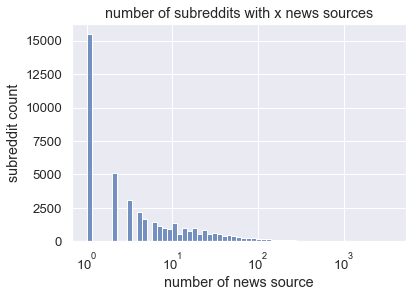

In [414]:
sns.histplot(nsc, log_scale=True)
plt.xlabel("number of news source")
plt.ylabel("subreddit count")
plt.title("number of subreddits with x news sources")

In [415]:
len([n for n in nsc if n>=20])

6966

I want to investigate and choose a subset of subreddits in the set of those that have 20 or more different news sources.

In [416]:
nsc_ge20 = []
for n in nsc_count:
    if nsc_count[n] >= 20:
        nsc_ge20.append(n)

In [417]:
len(nsc_ge20)

6966

In [418]:
import csv

```
with open("nsc_ge20.xlsx", "w", newline='', encoding="utf-8") as c:
    cw = csv.writer(c, delimiter=",", dialect="excel")
    for n in nsc_ge20:
        cw.writerow([n,"https://www.reddit.com/r/{}".format(n)])
```

In [419]:
subreddit_ns_jan["learnwelsh"]

{'bbc.co.uk': [3, 2.93, 23],
 'mit.edu': [1, 1.0, 0],
 'wiktionary.org': [2, 2.0, 0]}

How many subreddits only mentioned 5 news sources or less?

In [420]:
def pct_subreddits_mentioning_k_newssources(ks):
    sr_mention_i_nsc = [k for k in nsc_count if nsc_count[k] <= ks]
    count = len(sr_mention_i_nsc)
    print("There are {} subreddits mentioning in only {} news sources or less ({}%)".format(count, ks, count/len(sr_union)))
    return count/len(sr_union)

In [421]:
pct_subreddits_mentioning_k_newssources(1)

There are 15474 subreddits mentioning in only 1 news sources or less (0.3532876712328767%)


0.3532876712328767

In [422]:
# mean
statistics.mean(nsc)

17.059817351598173

In [423]:
# median
statistics.median(nsc)

3.0

## For each subreddit let's count total submissions that are news source related

In [424]:
def get_submission_count(sb):
    """get total mention count of ns in all six months"""
    count = 0
    files = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
    for f in files:
        sb_dict = f.get(sb, dict())
        if len(sb_dict) > 0:
            mentions = sum([m[0] for m in sb_dict.values()])
            count += mentions
    return count

In [425]:
mention_count = dict()
for sb in sr_union:
    mention_count[sb] = get_submission_count(sb)

In [426]:
statistics.mean(mention_count.values())

160.93561643835616

In [427]:
statistics.stdev(mention_count.values())

3216.3764939913694

In [428]:
statistics.median(mention_count.values())

5.0

In [429]:
len(mention_count)

43800

In [430]:
Counter(mention_count).most_common(20)

[('AutoNewspaper', 582301),
 ('politics', 136901),
 ('TheNewsFeed', 91784),
 ('news', 84659),
 ('TrendingQuickTVnews', 82824),
 ('COVID_CANADA', 76571),
 ('worldnews', 68589),
 ('Conservative', 53943),
 ('THEHINDUauto', 44130),
 ('niuz', 43845),
 ('NoFilterNews', 43262),
 ('FakeCollegeFootball', 41241),
 ('nofeenews', 40684),
 ('TORONTOSTARauto', 39281),
 ('trendandstyle', 38133),
 ('CertifiedNews', 38011),
 ('WrestlingBreakingNews', 37277),
 ('FOXauto', 36228),
 ('NewsfeedForWork', 34863),
 ('Coronavirus', 34076)]

In [431]:
ns_subreddit_01['cbc.ca']

{'todayilearned': [17, 14.780000000000001, 2038],
 'JoeRogan': [1, 0.76, 3],
 'knowyourshit': [3, 2.92, 1],
 'collapse': [7, 6.280000000000001, 58],
 'marginal': [3, 3.0, 0],
 'conspiracy': [11, 8.9, 649],
 'politics': [121, 107.37999999999998, 227661],
 'CPTSD': [1, 1.0, 1],
 'VideoEditing': [1, 0.98, 38],
 'wallstreetbets': [15, 13.129999999999999, 115],
 'hackernews': [8, 5.92, 8],
 'patient_hackernews': [8, 8.0, 8],
 'unitedkingdom': [2, 1.82, 19],
 'Catholicism': [1, 1.0, 2],
 'books': [6, 5.2, 15],
 'hackerdigest': [1, 1.0, 0],
 'Snorkblot': [2, 2.0, 2],
 'UnresolvedMysteries': [18, 17.439999999999998, 1033],
 'TrueUnpopularOpinion': [2, 1.3, 32],
 'SPACs': [2, 1.8, 152],
 'aznidentity': [1, 0.98, 40],
 'badgovnofreedom': [34, 34.0, 1],
 'cyberpunkgame': [1, 0.4, 3],
 'CBC_': [9, 8.84, 1],
 'newjersey': [1, 0.8, 25],
 'newfoundland': [28, 25.439999999999994, 406],
 'Hamilton': [42, 35.79, 950],
 'Oshawa': [1, 0.9, 5],
 'RedditTLDR': [5, 4.67, 1],
 'Sino': [1, 0.96, 18],
 'Sorcere

<AxesSubplot:ylabel='Count'>

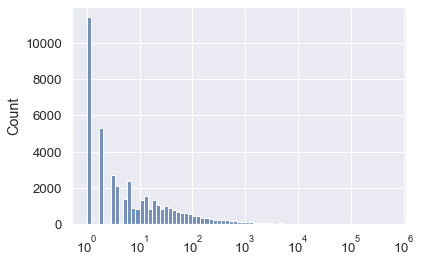

In [432]:
sns.histplot(list(mention_count.values()), log_scale=True)

<AxesSubplot:ylabel='Count'>

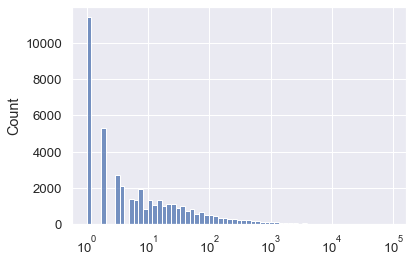

In [433]:
sns.histplot(list([k for k in mention_count.values() if k <100000]), log_scale=True)

In [434]:
len([k for k in mention_count.values() if k <5])*100/len(mention_count)

49.13470319634703

In [435]:
(1-0.35)*len(mention_count)

28470.0

## upvote based weight vs comment based weight 

Do they have correlation?

Let's look at January's data

In [436]:
upvote_based = [ns_subreddit_01[ns][sr][1] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]
comment_based = [ns_subreddit_01[ns][sr][2] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]
unweighted = [ns_subreddit_01[ns][sr][0] for ns in ns_subreddit_01 for sr in ns_subreddit_01[ns]]

(-5000.0, 150000.0)

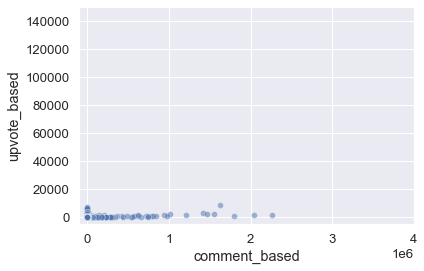

In [437]:
sns.scatterplot(x=comment_based, y=upvote_based, alpha=0.5)
plt.xlabel("comment_based")
plt.ylabel("upvote_based")
plt.xlim([-100000,4000000])
plt.ylim([-5000,150000])

Text(0, 0.5, 'upvote_based')

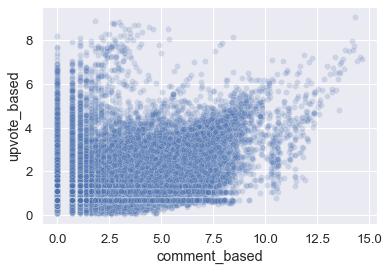

In [438]:
a = sns.scatterplot(x=np.log(np.array([c+1 for c in comment_based])), y=np.log(np.array([u+1 for u in upvote_based])), alpha=0.2)
plt.xlabel("comment_based")
plt.ylabel("upvote_based")

In [439]:
from scipy.stats import pearsonr

In [440]:
corr, _ = pearsonr(np.log(np.array([c+1 for c in comment_based])), np.log(np.array([u+1 for u in upvote_based])))
corr

0.4035266586811294

In [441]:
corr_raw, _ = pearsonr(comment_based, upvote_based)
corr_raw

0.23620470479544883

## I filter out news sources that are just too general

In [85]:
len(ns_union)

23575

In [86]:
len([k for k in ns_union if subreddit_count[k] > 1000])

131

In [87]:
non_outlier = [k for k in ns_union if subreddit_count[k] <= 1048 and subreddit_count[k] > 5]
len(non_outlier)

11436

In [88]:
subreddit_count['washingtonpost.com']

3654

In [89]:
'washingtonpost.com' in non_outlier

False

In [90]:
non_outlier

['zawya.com',
 'standard.net',
 'shu.edu',
 'abc7amarillo.com',
 'ij.org',
 'gamepressure.com',
 'ledevoir.com',
 'pearsonvue.com',
 'forum18.org',
 'kxnet.com',
 'theasset.com',
 'gao.gov',
 'thenational.scot',
 'visaliatimesdelta.com',
 'deadstate.org',
 'speedwaymedia.com',
 'agnetwest.com',
 'indialegallive.com',
 '25yearslatersite.com',
 'c4isrnet.com',
 'mastercard.com',
 'eldiariony.com',
 'examiner.net',
 'borneobulletin.com.bn',
 'square-enix-games.com',
 'lemonde.fr',
 'medgadget.com',
 'marvel.com',
 'thechurchnews.com',
 'pokernews.com',
 '14news.com',
 'ustream.tv',
 'adnkronos.com',
 'amacad.org',
 'businessam.be',
 'breastcancer.org',
 'sheboyganpress.com',
 'newrepublic.com',
 'ourcommunitynow.com',
 'caribbeannationalweekly.com',
 'forbesindia.com',
 'tradersmagazine.com',
 'milwaukeemag.com',
 'thepoultrysite.com',
 'developingtelecoms.com',
 'dayton247now.com',
 'wtap.com',
 'nngroup.com',
 'centralmaine.com',
 'badtaste.it',
 'qrius.com',
 'climatecentral.org',
 'te

## For now as a case study I will define `non_outlier` to be some news sources from MBFC

I will take out this step later

In [96]:
mbfc_left_raw = json.load(open(os.path.join(mbfc_path, "mbfc_left.json")))
len(mbfc_left_raw)

319

In [97]:
mbfc_right_raw = json.load(open(os.path.join(mbfc_path, "mbfc_right.json")))
len(mbfc_right_raw)

254

In [100]:
mbfc_left = [m[1] for m in mbfc_left_raw if m[1]]
mbfc_right = [m[1] for m in mbfc_right_raw if m[1]]

Cleaning the URLs for both `mbfc_left` and `mbfc_right`.

In [138]:
# for mbfc_left
mbfc_left_clean = set()
for ns in mbfc_left:
    extracted = tldextract.extract(ns)
    subdomain, domain, suffix = extracted
    # add both versions of domain.suffix and subdomain.domain.suffix
    full = ""
    # with subdomain
    if len(subdomain) > 0:
        #print(f"{subdomain}.{domain}.{suffix}")
        full = f"{subdomain}.{domain}.{suffix}"
        if len(full) > 0:
            mbfc_left_clean.add(full.replace("www.","").strip('/'))
    # without subdomain
    full = f"{domain}.{suffix}"
    if len(full) > 0:
        mbfc_left_clean.add(full.replace("www.","").strip('/'))
len(mbfc_left_clean)

292

In [139]:
# for mbfc_right
mbfc_right_clean = set()
for ns in mbfc_right:
    extracted = tldextract.extract(ns)
    subdomain, domain, suffix = extracted
    # add both versions of domain.suffix and subdomain.domain.suffix
    full = ""
    # with subdomain
    if len(subdomain) > 0:
        #print(f"{subdomain}.{domain}.{suffix}")
        full = f"{subdomain}.{domain}.{suffix}"
        if len(full) > 0:
            mbfc_right_clean.add(full.replace("www.","").strip('/'))
    # without subdomain
    full = f"{domain}.{suffix}"
    if len(full) > 0:
        mbfc_right_clean.add(full.replace("www.","").strip('/'))
len(mbfc_right_clean)

232

In [140]:
non_outlier = (mbfc_left_clean | mbfc_right_clean) & set(ns_union)
len(non_outlier)

266

## Cluster Try Out

First, I make a list of subreddits with fixed order, where I only include subreddits where our non_outlier news sources are mentioned in.

In [141]:
len(non_outlier)

266

In [142]:
# subreddits = subs
subreddits = set()
nsr_files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
# first, I filter for only the subreddits in which our news sources are mentioned
c = 0
for n in non_outlier:
    subreddits = (subreddits | set(ns_subreddit_01.get(n, dict()).keys()) 
                               | set(ns_subreddit_02.get(n, dict()).keys()) 
                               | set(ns_subreddit_03.get(n, dict()).keys()) 
                               | set(ns_subreddit_04.get(n, dict()).keys())
                               | set(ns_subreddit_05.get(n, dict()).keys()) 
                               | set(ns_subreddit_06.get(n, dict()).keys()))
    c += 1
    if c%100==0: print(f"done {c}")
subreddits = list(subreddits)
len(subreddits)

done 100
done 200


11128

There are 9195 subreddits.

In [143]:
subreddits[-10:]

['BillGatesBeingAwesome',
 'Nationals',
 'GenX',
 'Testosterone',
 'BeeGees',
 'NewYorkForSanders',
 'FreeKarma4U',
 'mazzystar',
 'turtleswithjobs',
 'vim']

If I should order them later, I can do so.

## Incorporating subscribers information

In [144]:
pd1 = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd1,"data/gm-newssources-subreddits")
dfp = os.path.join(pd1,"data")

In [145]:
sfp = os.path.join(pd1,"data/subreddits")

In [146]:
# Let's only use the subreddits that have lots of subscribers
with open (os.path.join(sfp,"subreddit_subscribers.json"), "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [147]:
subreddit_subscribers['politics']

6201779

In [148]:
len(subreddit_subscribers)

49055

In [149]:
len(subreddits)

11128

In [150]:
subreddits_w_subc = [k for k in subreddits if k in subreddit_subscribers]
len(subreddits_w_subc)

8455

It seems that there are `None` values, so let's filter those subreddits out.

In [151]:
print([s for s in subreddits_w_subc if subreddit_subscribers[s] is None])

['LoveForLandlords', 'DystopianFuture', 'RedditMobTest', 'JKRowling']


In [152]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]

In [153]:
len(subreddits_w_subc)

8451

Now, I will sort the 8,294 subreddits based on the # of their subscribers in a descending order.

In [154]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

Text(0.5, 1.0, 'Subreddits Subscribers')

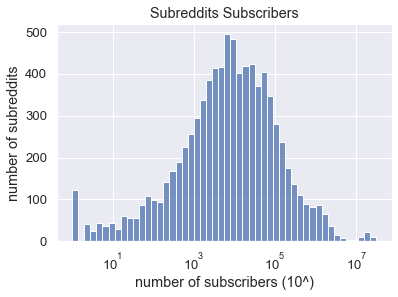

In [155]:
# plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all if subreddit_subscribers[s] > 0])
sns.histplot([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s]>0], log_scale=True)
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
# plt.yscale("log")
# plt.xscale("log")
plt.ylabel("number of subreddits")
plt.xlabel("number of subscribers (10^)")
plt.title("Subreddits Subscribers")
# log scale for both x and y

Which subreddits are the top three?

In [156]:
print([(s,subreddit_subscribers[s]) for s in srs_all if subreddit_subscribers[s]>25000000])

[('funny', 31060166), ('gaming', 26628444), ('aww', 25197817)]


In [157]:
dir(math)

['__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'acos',
 'acosh',
 'asin',
 'asinh',
 'atan',
 'atan2',
 'atanh',
 'ceil',
 'comb',
 'copysign',
 'cos',
 'cosh',
 'degrees',
 'dist',
 'e',
 'erf',
 'erfc',
 'exp',
 'expm1',
 'fabs',
 'factorial',
 'floor',
 'fmod',
 'frexp',
 'fsum',
 'gamma',
 'gcd',
 'hypot',
 'inf',
 'isclose',
 'isfinite',
 'isinf',
 'isnan',
 'isqrt',
 'ldexp',
 'lgamma',
 'log',
 'log10',
 'log1p',
 'log2',
 'modf',
 'nan',
 'perm',
 'pi',
 'pow',
 'prod',
 'radians',
 'remainder',
 'sin',
 'sinh',
 'sqrt',
 'tan',
 'tanh',
 'tau',
 'trunc']

In [158]:
list(subreddit_subscribers.values()).count(None)

25

In [159]:
statistics.median([k for k in list(subreddit_subscribers.values()) if k is not None])

1420.0

In [160]:
statistics.mean([k for k in list(subreddit_subscribers.values()) if k is not None])

50070.832184376915

## Building `ns_repr`

Which will be in the form of feature-based matrix, where each row represents a news source, and columns representing subreddits. Each subreddit will be represented by 18 columns: unweighted count, upvote based weighted count, and comment based weighted count for each of the six months that we are interested in.

In [161]:
srs = srs_all

In [162]:
a = {"a": 1, "b": 2}
b = {"b": 1, "c": 2}
res = {**a, **b}
res

{'a': 1, 'b': 1, 'c': 2}

For each news source, I create a list of length `(3 * # subreddits)`.

Old code
```
# here I will cast the inner dictionaries of ns_subreddits to be Counter so I can avoid a lot of if-else statements
files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
for f in files:
    for k in f: # k is each news source
        for ns in f[k]:
            # averaging based on weighted counts
            count, upv, comm = f[k][ns]
            avg = (upv + comm)/count
            f[k][ns] = avg
        f[k] = Counter(f[k])
```

In [163]:
files_sub = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

In [164]:
len(non_outlier)

266

In [165]:
len(srs)

8451

I tried and found out that using all 23.7k subreddits results in MemoryError. So I should use less

In [206]:
srs = srs_all[:5000]

In [234]:
ns_sr_rep = defaultdict(list)
default_counter = Counter() # to avoid a lot of if else statements

ncount = 0

# for ns in nss:
for ns in non_outlier:
    # for each news sources, construct the 18*length(subreddits) features
    for f in files_sub:
        for idx in range(len(srs)):
            # making sure the ordering follows `srs` based on subscribers
            ns_sr_rep[ns] += f[ns][srs[idx]][1:] if (ns in f and srs[idx] in f[ns]) else [0, 0]
    ncount += 1
    if ncount%200==0: print(ncount)

200


    code started at 22:56

Let's see one example of representation for `nytimes.com`.

In [235]:
len(ns_sr_rep['amsterdamnews.com'])

60000

Let's investigate the sparsity of our data

In [236]:
from numpy import array
from numpy import count_nonzero
from scipy.sparse import csr_matrix

In [237]:
# ns_repr, ns_fixed = np.array([v[1] for v in items]), list([v[0] for v in items]) # this causes memory error
## MemoryError: Unable to allocate 15.3 GiB for an array with shape (11436, 180000) and data type float64
items = ns_sr_rep.items()
ns_repr = np.array([v[1] for v in items])

In [238]:
sparsity = 1.0 - np.count_nonzero(ns_repr)/ns_repr.size

In [239]:
sparsity

0.9944756265664161

Wow very high sparsity.

In [240]:
# convert to sparse matrix (CSR method)
S = csr_matrix(ns_repr)
print(S)

  (0, 24492)	1.22
  (0, 24493)	6.0
  (0, 24982)	1.68
  (0, 24983)	8.0
  (0, 33258)	1.34
  (0, 33259)	4.0
  (0, 35526)	1.0
  (0, 40716)	0.3
  (0, 40717)	3.0
  (0, 42920)	0.92
  (0, 42921)	25.0
  (0, 45136)	0.57
  (0, 45137)	2.0
  (0, 52920)	1.0
  (0, 52921)	9.0
  (0, 54792)	1.66
  (0, 54793)	6.0
  (0, 58094)	1.82
  (0, 58095)	6.0
  (1, 386)	0.5
  (1, 406)	0.54
  (1, 407)	2.0
  (1, 1068)	0.62
  (1, 1069)	2.0
  (1, 1732)	0.86
  :	:
  (265, 29212)	0.92
  (265, 29213)	1.0
  (265, 33876)	0.97
  (265, 33877)	88.0
  (265, 35262)	0.84
  (265, 35263)	1.0
  (265, 35508)	0.9
  (265, 35509)	3.0
  (265, 38112)	0.98
  (265, 38113)	25.0
  (265, 38688)	0.98
  (265, 38689)	4.0
  (265, 42990)	1.86
  (265, 42991)	18.0
  (265, 44756)	0.99
  (265, 44757)	5.0
  (265, 46054)	1.34
  (265, 46055)	42.0
  (265, 51260)	1.0
  (265, 55152)	1.0
  (265, 55153)	4.0
  (265, 57040)	0.87
  (265, 57041)	17.0
  (265, 58168)	1.0
  (265, 58169)	11.0


### Now PCA

In [241]:
# svd = TruncatedSVD(n_components=len(srs)) #, n_iter=7, random_state=42)
svd = PCA(n_components=len(ns_repr))

In [242]:
svd.fit(ns_repr)

PCA(n_components=266)

In [243]:
explained_var = svd.explained_variance_ratio_

In [244]:
len(explained_var)

266

In [245]:
svd.explained_variance_ratio_.sum()

0.9999999999999999

In [246]:
explained_var_sums = [sum(explained_var[:d]) for d in range(len(ns_repr))]

c:\users\user200803\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

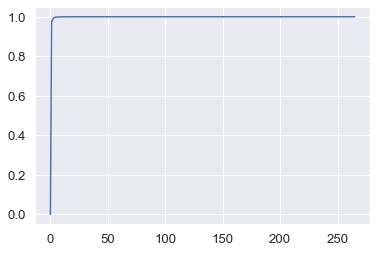

In [247]:
sns.lineplot(range(len(explained_var_sums)), explained_var_sums)

Now, I will cast those list representation values to be numpy arrays so I can preprocess them easily. Further, I will normalize each array.

*side note: `preprocessing.normalize` vs `standardscaler`*

In [160]:
preprocessing.normalize(np.array([[1,100,2,3]]))

array([[0.00999301, 0.99930073, 0.01998601, 0.02997902]])

In [161]:
scaler = StandardScaler()
scaler.fit_transform(np.array([[1,100,2,3]]))

array([[0., 0., 0., 0.]])

Now I'm thinking, should I *normalize* or *standardize*?

In [162]:
# for ns in ns_sr_rep:
#     rep = ns_sr_rep[ns]
#     ns_sr_rep[ns] = preprocessing.normalize(np.array([rep]))

## K-Means

Without standardization.

First, I need to find optimum `k`.

In [163]:
kmeans = KMeans(init = "k-means++",
               n_clusters = 5,
               n_init = 10,
               max_iter = 100)

Freezing the list for representations and the news sources.

In [166]:
kmeans.fit([v for v in ns_sr_rep.values()])

KMeans(max_iter=100, n_clusters=5)

In [167]:
for i,ns in enumerate(ns_fixed):
    if (ns_sr_rep[ns] == ns_repr[i]).all():
        pass
    else:
        print("False")
print("True")

True


In [168]:
kmeans.inertia_

9826851082.529928

In [169]:
kmeans.n_iter_

6

In [170]:
Counter(kmeans.labels_)

Counter({0: 11357, 1: 12, 4: 63, 3: 1, 2: 3})

**Choosing the appropriate number of clusters**

1. Elbow method

In [171]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 360
}

In [172]:
sse = []
for k in range(1,20):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 1 rounds, current sse is [23449436924.745914]
have done 2 rounds, current sse is [23449436924.745914, 16403619369.069223]
have done 3 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112]
have done 4 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285]
have done 5 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078]
have done 6 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668]
have done 7 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146]
have done 8 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146, 8371371167.842005

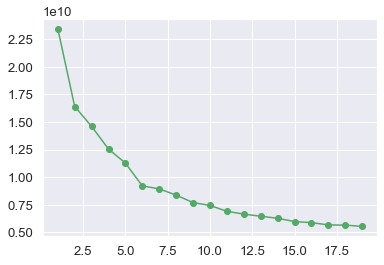

In [173]:
plt.plot(range(1,20),sse,"go-")

In [174]:
for k in range(20,41):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    sse.append(kmeans.inertia_)
    print(f"have done {k} rounds, current sse is {sse}")

have done 20 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146, 8371371167.842005, 7697802761.991763, 7439467031.309094, 6909310699.419428, 6654306963.26893, 6460188757.661017, 6276347552.998721, 5979781661.205648, 5881229904.03242, 5676602292.103157, 5656836846.585837, 5538944833.53924, 5264175921.681719]
have done 21 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146, 8371371167.842005, 7697802761.991763, 7439467031.309094, 6909310699.419428, 6654306963.26893, 6460188757.661017, 6276347552.998721, 5979781661.205648, 5881229904.03242, 5676602292.103157, 5656836846.585837, 5538944833.53924, 5264175921.681719, 5177587995.900417]
have done 22 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 920629

have done 35 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146, 8371371167.842005, 7697802761.991763, 7439467031.309094, 6909310699.419428, 6654306963.26893, 6460188757.661017, 6276347552.998721, 5979781661.205648, 5881229904.03242, 5676602292.103157, 5656836846.585837, 5538944833.53924, 5264175921.681719, 5177587995.900417, 5076006046.41951, 5026174131.257136, 4901619684.296674, 4882122799.429097, 4832986116.720473, 4710014917.251001, 4690824268.634267, 4586651962.452597, 4418465371.553158, 4423859659.081299, 4339081133.524831, 4264385831.917897, 4239911818.1692686, 4098709969.3477373]
have done 36 rounds, current sse is [23449436924.745914, 16403619369.069223, 14601469660.918112, 12545894031.450285, 11272340605.480078, 9206299986.068668, 8944935005.953146, 8371371167.842005, 7697802761.991763, 7439467031.309094, 6909310699.419428, 6654306963.26893, 6460188757.661017, 6276347

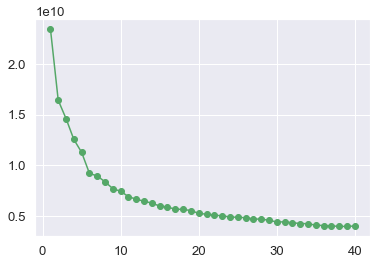

In [175]:
plt.plot(range(1,41),sse,"go-")

In [176]:
kl = KneeLocator(range(1,41), sse, curve="convex", direction="decreasing")

In [177]:
kl.elbow

11

**Using Silhouette Coefficient**

In [178]:
sc = []
new_sse = []
for k in range(2,30):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(ns_repr)
    score = silhouette_score(ns_repr, kmeans.labels_)
    sc.append(score)
    new_sse.append(kmeans.inertia_)
    print("step {}".format(k))

step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29


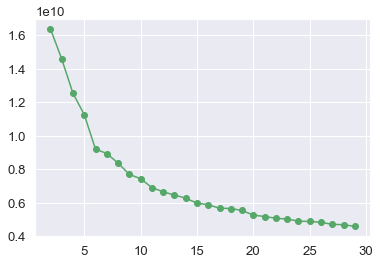

In [180]:
# for sse
plt.plot(range(2,30), new_sse, "go-")

In [181]:
kl_new = KneeLocator(range(2,30), new_sse, curve="convex", direction="decreasing")
kl_new.elbow

11

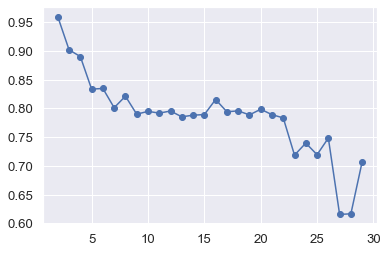

In [182]:
# for silhouette coefficient
plt.plot(range(2,30), sc, "bo-")

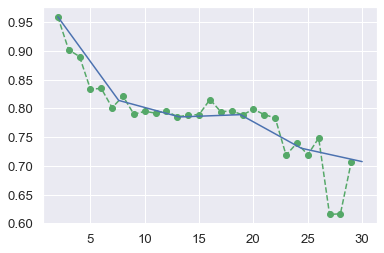

In [184]:


spl = make_interp_spline(range(2,30), sc, k=3)  # type: BSpline

xs = np.linspace(2, 30, 6)
ys = spl(xs)

plt.plot(range(2,30), sc, "go--")
plt.plot(xs, ys, "b-")

Let's choose k = 10

In [185]:
kmeans = KMeans(n_clusters = 8, init="k-means++", n_init = 50, max_iter = 500, random_state = 360)
kmeans.fit(ns_repr)

KMeans(max_iter=500, n_init=50, random_state=360)

In [68]:
dir(kmeans)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_algorithm',
 '_check_feature_names',
 '_check_mkl_vcomp',
 '_check_n_features',
 '_check_params',
 '_check_test_data',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_init_centroids',
 '_more_tags',
 '_n_init',
 '_n_threads',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_tol',
 '_transform',
 '_validate_center_shape',
 '_validate_data',
 'algorithm',
 'cluster_centers_',
 'copy_x',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inertia_',
 'init',
 'labels_',
 'max_iter',
 'n_clusters',
 'n_features_in_',
 'n_init',
 'n_iter_',
 'predict',
 'random_

In [186]:
kmeans.labels_

array([7, 7, 7, ..., 7, 7, 7])

In [187]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7}

In [188]:
Counter(kmeans.labels_)

Counter({7: 11200, 0: 96, 3: 110, 1: 5, 4: 1, 2: 3, 6: 20, 5: 1})

**Let's investigate each cluster**

In [317]:
len(ns_sr_rep)

12172

In [318]:
len(kmeans.labels_)

12172

In [319]:
clustered = defaultdict(list)
for idx,ns in enumerate(ns_fixed):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [320]:
print([len(clustered[i]) for i in range(10)])

[11739, 20, 177, 82, 103, 1, 13, 37, 0, 0]


Let's see in terms of percentage

In [321]:
cluster_lens = [len(clustered[i]) for i in range(10)]

In [322]:
print([round(k*100/sum(cluster_lens),2) for k in cluster_lens])

[96.44, 0.16, 1.45, 0.67, 0.85, 0.01, 0.11, 0.3, 0.0, 0.0]


 **could do iterative clusters for ^**

In [325]:
clustered[2]

['opb.org',
 'actionnewsnow.com',
 'okcfox.com',
 'wmot.org',
 'aviationweek.com',
 'vulture.com',
 'wtop.com',
 'jns.org',
 'dutchnews.nl',
 'woodworkingnetwork.com',
 'wvmetronews.com',
 'nbc-2.com',
 'nbc12.com',
 'fox2detroit.com',
 'wvnstv.com',
 'thelily.com',
 'kbzk.com',
 'kktv.com',
 'rentonreporter.com',
 'montreal.ctvnews.ca',
 'nbcchicago.com',
 'nwaonline.com',
 'theadvocate.com',
 'whdh.com',
 'expressnews.com',
 'fox29.com',
 'mlive.com',
 'lbc.co.uk',
 'uptownmessenger.com',
 'nbcsports.com',
 'duluthnewstribune.com',
 'wfmj.com',
 'fox26houston.com',
 'abc15.com',
 'abc30.com',
 'toronto.citynews.ca',
 'wqow.com',
 'kiro7.com',
 'wgem.com',
 'prpeak.com',
 'denverpost.com',
 'kpvi.com',
 'fox4news.com',
 'desmoinesregister.com',
 'metrotimes.com',
 'local12.com',
 'fox7austin.com',
 'tmj4.com',
 'theregister.com',
 'news4sanantonio.com',
 'govexec.com',
 'fox11online.com',
 'wearemitu.com',
 'wsvn.com',
 'wafb.com',
 'nzherald.co.nz',
 'fox21news.com',
 'chicagocrusade

## DBSCAN clustering

In [326]:
from sklearn.cluster import DBSCAN

First try out.

In [327]:
dbscan = DBSCAN(eps=0.01)

In [328]:
ds_clusters = dbscan.fit(ns_repr)

In [329]:
dbs_labels = ds_clusters.labels_
len(dbs_labels)

12172

In [330]:
np.unique(dbs_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37], dtype=int64)

In [331]:
dbscan_clusters = defaultdict(list)
for idx, c in enumerate(list(dbs_labels)):
    dbscan_clusters[c].append(ns_fixed[idx])

In [332]:
for c in range(-1, 38):
    print("number of ns in cluster {}: {}".format(c, len(dbscan_clusters[c])))

number of ns in cluster -1: 6236
number of ns in cluster 0: 5206
number of ns in cluster 1: 13
number of ns in cluster 2: 102
number of ns in cluster 3: 22
number of ns in cluster 4: 6
number of ns in cluster 5: 12
number of ns in cluster 6: 192
number of ns in cluster 7: 7
number of ns in cluster 8: 31
number of ns in cluster 9: 53
number of ns in cluster 10: 37
number of ns in cluster 11: 5
number of ns in cluster 12: 20
number of ns in cluster 13: 17
number of ns in cluster 14: 5
number of ns in cluster 15: 26
number of ns in cluster 16: 8
number of ns in cluster 17: 5
number of ns in cluster 18: 5
number of ns in cluster 19: 6
number of ns in cluster 20: 12
number of ns in cluster 21: 8
number of ns in cluster 22: 24
number of ns in cluster 23: 5
number of ns in cluster 24: 13
number of ns in cluster 25: 7
number of ns in cluster 26: 5
number of ns in cluster 27: 6
number of ns in cluster 28: 10
number of ns in cluster 29: 5
number of ns in cluster 30: 5
number of ns in cluster 31:

Let's investigate some of the clusters

In [342]:
dbscan_clusters[9]

['smdailyjournal.com',
 'news-gazette.com',
 'sakshi.com',
 'tortoisemedia.com',
 'berlingske.dk',
 'eleconomista.com.mx',
 'letelegramme.fr',
 'odishatv.in',
 'moneylife.in',
 'thelastamericanvagabond.com',
 'hankookilbo.com',
 'ekstrabladet.dk',
 'todayheadline.co',
 'wellnessmama.com',
 'ticotimes.net',
 'eldiariony.com',
 'carehome.co.uk',
 'phnompenhpost.com',
 'mediafax.ro',
 'rcrwireless.com',
 'wigantoday.net',
 'parismatch.com',
 'biznews.com',
 'vedomosti.ru',
 'iz.ru',
 'dailycardinal.com',
 'fashionweekdaily.com',
 'searchenginewatch.com',
 'techinasia.com',
 'azernews.az',
 'surfacemag.com',
 'animalpolitico.com',
 'icirnigeria.org',
 'salaamgateway.com',
 'n-tv.de',
 'vavel.com',
 'myfitnesspal.com',
 'thecitizen.com',
 '2gb.com',
 'dopemagazine.com',
 'livehindustan.com',
 'niagarathisweek.com',
 'lowyat.net',
 'kbjr6.com',
 'smartinsights.com',
 'theglobalist.com',
 'atheistrepublic.com',
 'dinheirovivo.pt',
 'sabah.com.tr',
 'lenta.ru',
 'goldswitzerland.com',
 'mounta

In [147]:
dbscan_clusters[1]

[]

**Finding optimum `epsilon` for dbscan**

References: 

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In [343]:
from sklearn.neighbors import NearestNeighbors

In [344]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(ns_repr)
distances, indices = nbrs.kneighbors(ns_repr)

(0.0, 0.01)

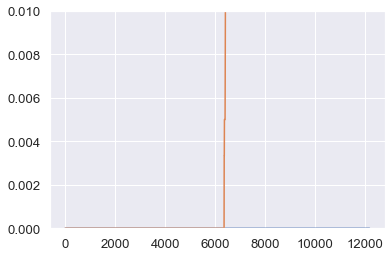

In [348]:
distances = np.sort(distances, axis=0)
# distances = distances[:,1]
plt.plot(distances)
plt.ylim((0,0.01))

I don't think any epsilon makes sense here.